<a href="https://colab.research.google.com/github/tahabinzafar/Electricity-Demand-Prediction/blob/main/Predicting_Electricity_Demand.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import xgboost as xg
from sklearn.metrics import mean_squared_error

## **Data by American Electric Power - Energy Consumption in MW**

In [6]:
df = pd.read_csv('AEP_hourly.csv')

In [7]:
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

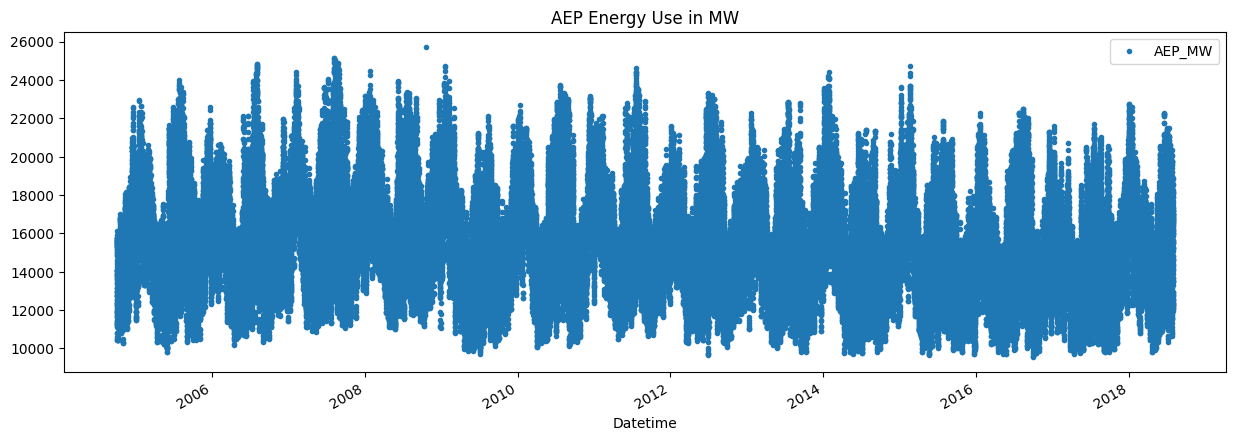

In [8]:
df.plot(style='.',
        figsize=(15, 5),
        title='AEP Energy Use in MW')
plt.show()

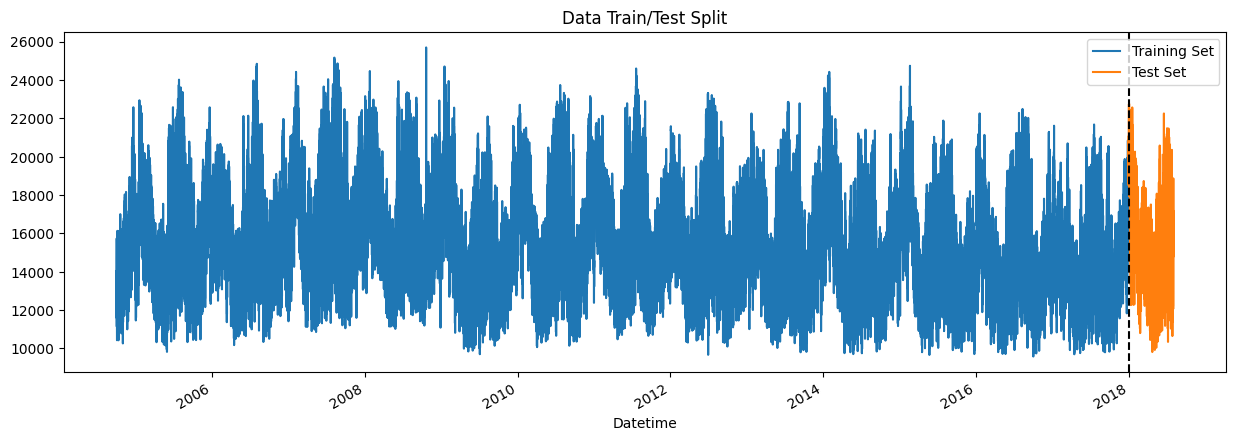

In [9]:
train = df.loc[df.index < '01-01-2018']
test = df.loc[df.index >= '01-01-2018']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2018', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

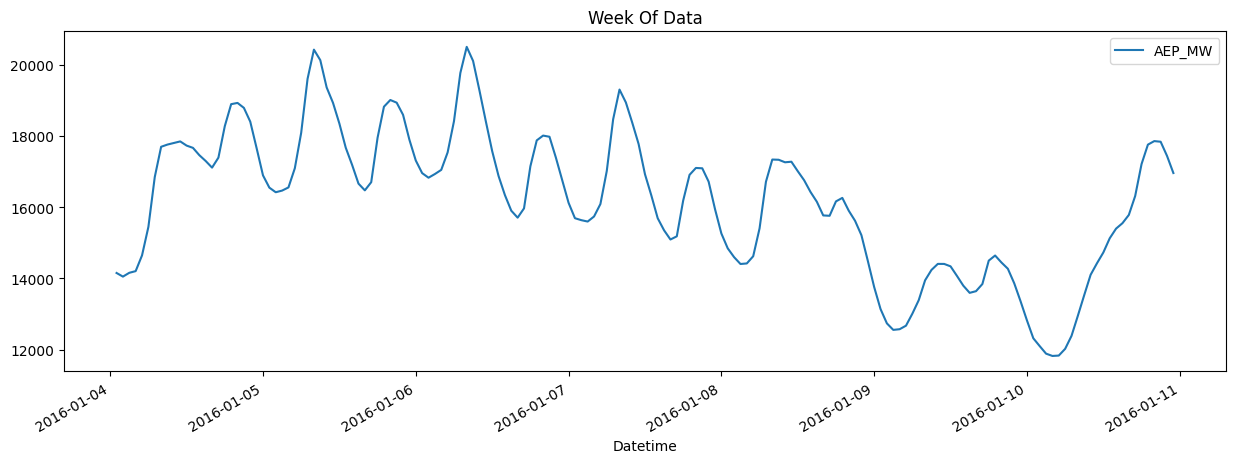

In [10]:
df.loc[(df.index > '01-04-2016') & (df.index < '01-11-2016')] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()

In [11]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

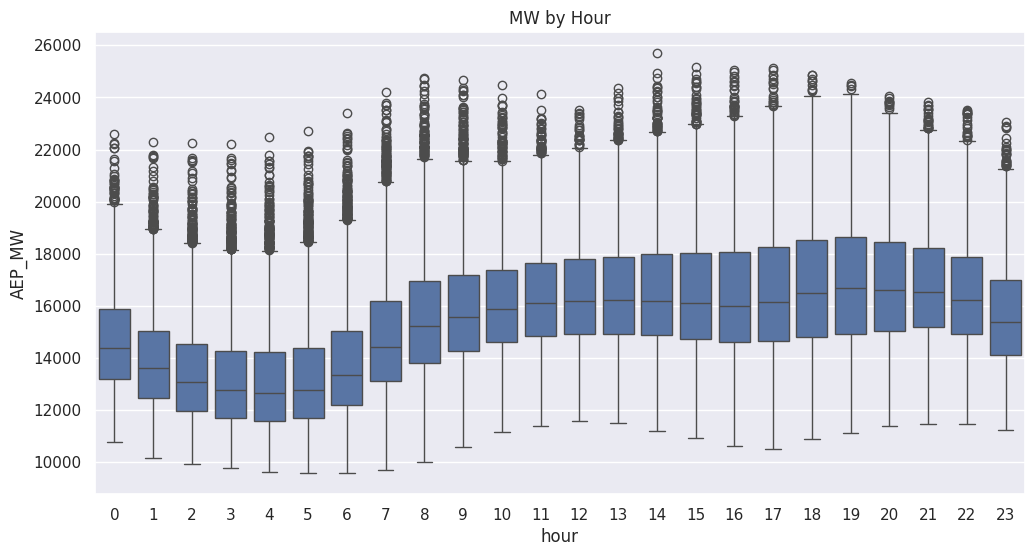

In [12]:
sns.set()

fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(data=df, x='hour', y='AEP_MW')
ax.set_title('MW by Hour')

plt.show()

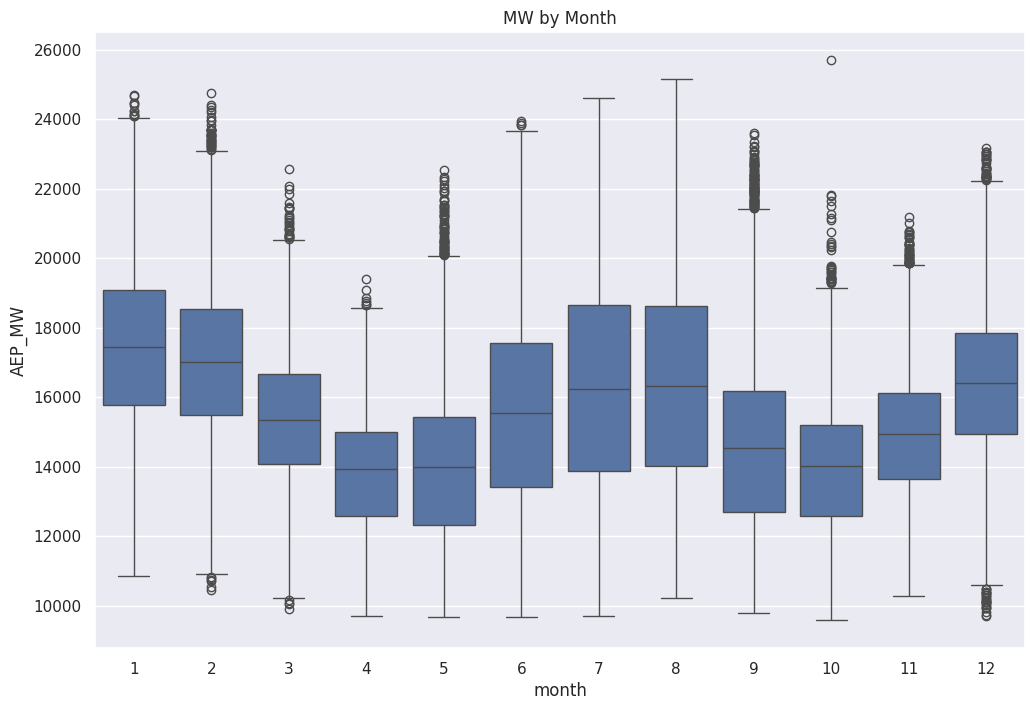

In [13]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.boxplot(data=df, x='month', y='AEP_MW')
ax.set_title('MW by Month')
plt.show()

In [14]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'AEP_MW'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [15]:
reg = xg.XGBRegressor(base_score=0.5, booster='gbtree',
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=20,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [00:09:58] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:15567.85065	validation_1-rmse:15350.76830
[100]	validation_0-rmse:5815.14322	validation_1-rmse:6279.10781
[200]	validation_0-rmse:2276.74815	validation_1-rmse:3167.69419
[300]	validation_0-rmse:974.67464	validation_1-rmse:2239.97976
[400]	validation_0-rmse:458.63994	validation_1-rmse:2000.61170
[500]	validation_0-rmse:243.12858	validation_1-rmse:1935.87664
[600]	validation_0-rmse:147.51419	validation_1-rmse:1918.14083
[700]	validation_0-rmse:97.93278	validation_1-rmse:1912.39715
[800]	validation_0-rmse:71.95968	validation_1-rmse:1911.46220
[858]	validation_0-rmse:61.59065	validation_1-rmse:1911.53286


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=20, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

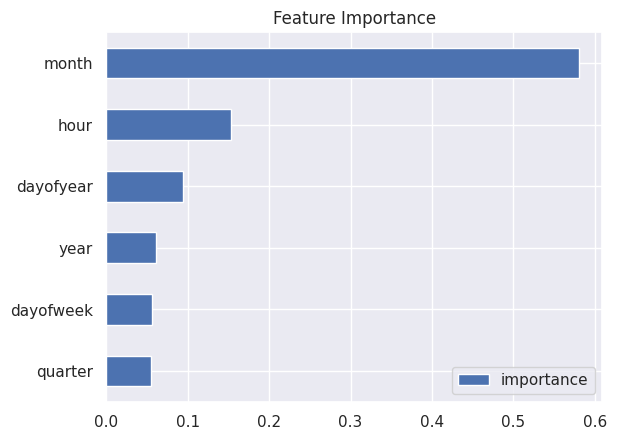

In [20]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [21]:
test['prediction'] = reg.predict(X_test)


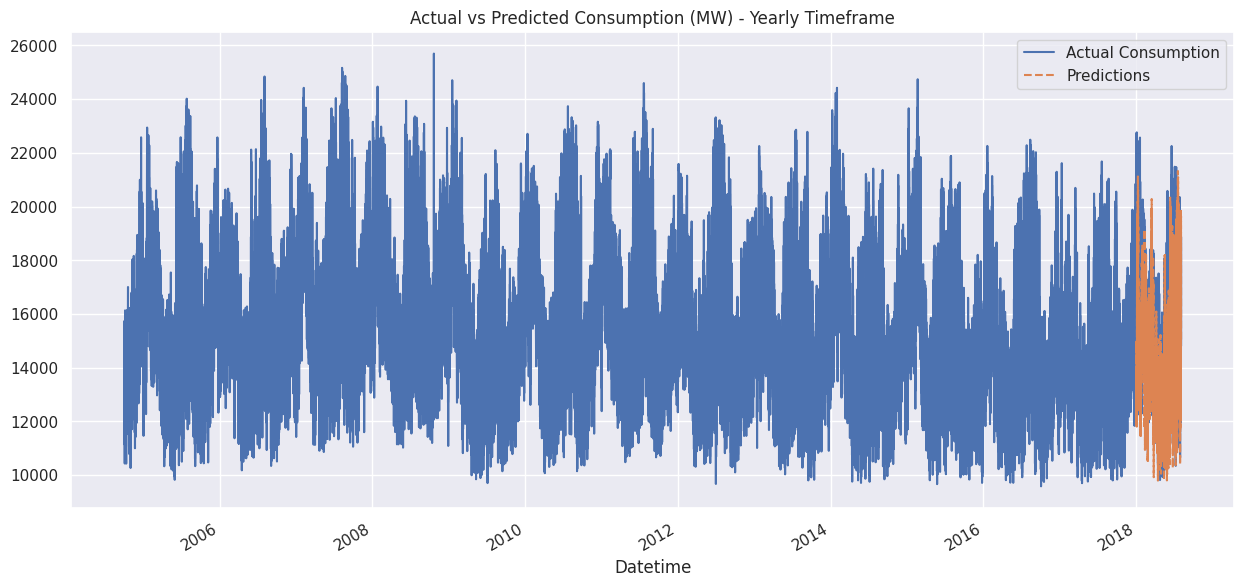

In [23]:
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['AEP_MW']].plot(figsize=(15, 7))


df['prediction'].plot(ax=ax, style='--')
plt.legend(['Actual Consumption', 'Predictions'])
ax.set_title('Actual vs Predicted Consumption (MW) - Yearly Timeframe')
plt.show()

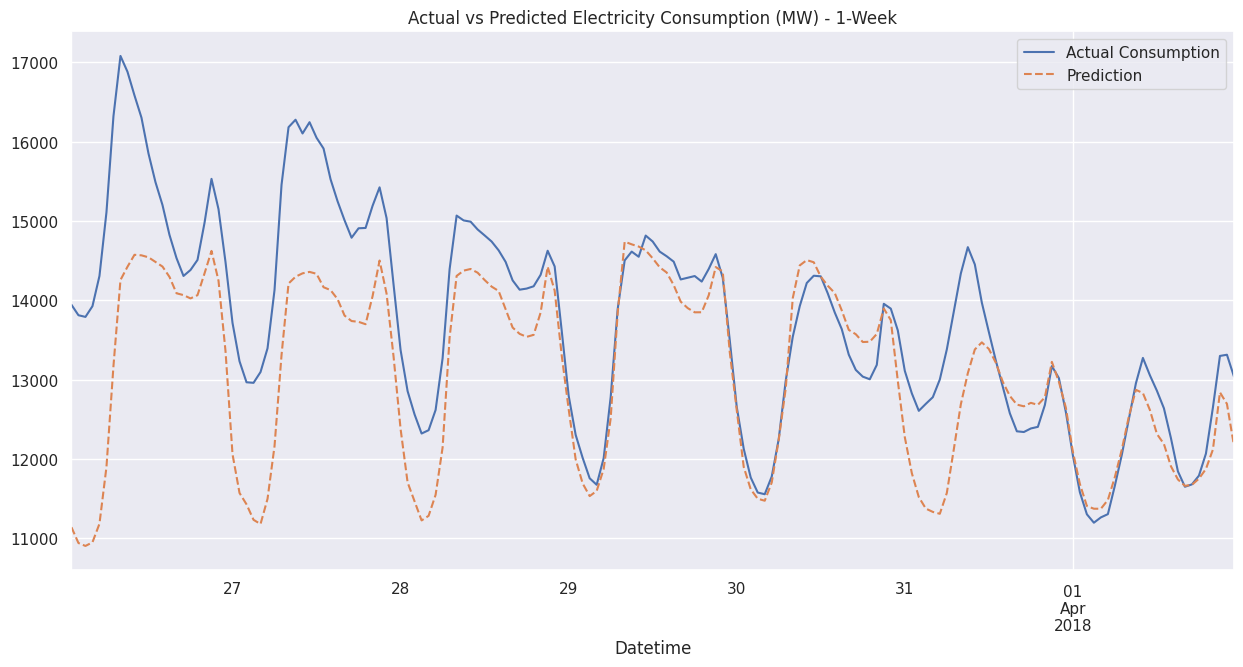

In [28]:
ax = df.loc[(df.index > '03-26-2018') & (df.index < '04-02-2018')]['AEP_MW'] \
    .plot(figsize=(15, 7), title='Actual vs Predicted Electricity Consumption (MW) - 1-Week')
df.loc[(df.index > '03-26-2018') & (df.index < '04-02-2018')]['prediction'] \
    .plot(style='--')
plt.legend(['Actual Consumption','Prediction'])
plt.show()